In [2]:
import numpy as np
import sympy as smp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

<p align="center">
  <img src="doub_pen.png" alt="drawing" width="300" align="center"/>
</p>

Define all appropriate symbols using sympy. 

In [3]:
t, g = smp.symbols('t g')
m1, m2 = smp.symbols('m1 m2')
L1, L2 = smp.symbols('L1, L2')

$\theta_1$ and $\theta_2$ are functions of time (which we will eventually solve for). We need to define them carefully.

In [4]:
the1, the2 = smp.symbols(r'\theta_1, \theta_2', cls=smp.Function)

Explicitly write them as functions of time $t$:

In [5]:
the1 = the1(t)
the2 = the2(t)

In [6]:
the1

\theta_1(t)

Define derivatives and second derivatives

In [7]:
the1_d = smp.diff(the1, t)
the2_d = smp.diff(the2, t)
the1_dd = smp.diff(the1_d, t)
the2_dd = smp.diff(the2_d, t)

Define $x_1$, $y_1$, $x_2$, and $y_2$ written in terms of the parameters above.

In [8]:
x1 = L1*smp.sin(the1)
y1 = -L1*smp.cos(the1)
x2 = L1*smp.sin(the1)+L2*smp.sin(the2)
y2 = -L1*smp.cos(the1)-L2*smp.cos(the2)

Then use these to define kinetic and potential energy for each mass. Obtain the Lagrangian

In [9]:
# Kinetic
T1 = 1/2 * m1 * (smp.diff(x1, t)**2 + smp.diff(y1, t)**2)
T2 = 1/2 * m2 * (smp.diff(x2, t)**2 + smp.diff(y2, t)**2)
T = T1+T2
# Potential
V1 = m1*g*y1
V2 = m2*g*y2
V = V1 + V2
# Lagrangian
L = T-V

In [10]:
L

L1*g*m1*cos(\theta_1(t)) - g*m2*(-L1*cos(\theta_1(t)) - L2*cos(\theta_2(t))) + 0.5*m1*(L1**2*sin(\theta_1(t))**2*Derivative(\theta_1(t), t)**2 + L1**2*cos(\theta_1(t))**2*Derivative(\theta_1(t), t)**2) + 0.5*m2*((L1*sin(\theta_1(t))*Derivative(\theta_1(t), t) + L2*sin(\theta_2(t))*Derivative(\theta_2(t), t))**2 + (L1*cos(\theta_1(t))*Derivative(\theta_1(t), t) + L2*cos(\theta_2(t))*Derivative(\theta_2(t), t))**2)

Get Lagrange's equations

$$\frac{\partial L}{\partial \theta_1} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}} = 0$$
$$\frac{\partial L}{\partial \theta_2} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}} = 0$$

In [11]:
LE1 = smp.diff(L, the1) - smp.diff(smp.diff(L, the1_d), t).simplify()
LE2 = smp.diff(L, the2) - smp.diff(smp.diff(L, the2_d), t).simplify()

Solve Lagranges equations (this assumes that `LE1` and `LE2` are both equal to zero)

In [12]:
sols = smp.solve([LE1, LE2], (the1_dd, the2_dd),
                simplify=False, rational=False)

Now we have 

* $\frac{d^2 \theta_1}{dt^2} = ...$
* $\frac{d^2 \theta_2}{dt^2} = ...$

These are two second order ODEs! In python we can only solve systems of first order ODEs. Any system of second order ODEs can be converted as follows:

1. Define $z_1 = d\theta_1/dt$ and $z_2=d\theta_2/dt$
2. Then $dz_1/dt = d^2\theta_1/dt^2$ and $dz_2/dt = d^2\theta_2/dt^2$

Now we get a system of 4 first order ODEs (as opposed to 2 second order ones)

* $d z_1/dt = ...$
* $d\theta_1/dt = z_1$
* $d z_2/dt = ...$
* $d\theta_2/dt = z_1$

We need to convert the **symbolic** expressions above to numerical functions so we can use them in a numerical python solver. For this we use `smp.lambdify`

In [13]:
dz1dt_f = smp.lambdify((t,g,m1,m2,L1,L2,the1,the2,the1_d,the2_d), sols[the1_dd])
dz2dt_f = smp.lambdify((t,g,m1,m2,L1,L2,the1,the2,the1_d,the2_d), sols[the2_dd])
dthe1dt_f = smp.lambdify(the1_d, the1_d)
dthe2dt_f = smp.lambdify(the2_d, the2_d)

Now define $\vec{S} = (\theta_1, z_1, \theta_2, z_2)$. IF we're going to use an ODE solver in python, we need to write a function that takes in $\vec{S}$ and $t$ and returns $d\vec{S}/dt$. In other words, we need to define $d\vec{S}/dt (\vec{S}, t)$

* Our system of ODEs can be fully specified using $d\vec{S}/dt$ and depends only on $\vec{S}$ and $t$

In [14]:
def dSdt(S, t, g, m1, m2, L1, L2):
    the1, z1, the2, z2 = S
    return [
        dthe1dt_f(z1),
        dz1dt_f(t, g, m1, m2, L1, L2, the1, the2, z1, z2),
        dthe2dt_f(z2),
        dz2dt_f(t, g, m1, m2, L1, L2, the1, the2, z1, z2),
    ]

Solve the system of ODEs using scipys `odeint` method

In [15]:
t = np.linspace(0, 40, 1001)
g = 9.81
m1=2
m2=1
L1 = 2
L2 = 1
ans = odeint(dSdt, y0=[1, -3, -1, 5], t=t, args=(g,m1,m2,L1,L2))

25 times per second (number of data points). This will be important for animating later on.

In [16]:
ans.T

array([[  1.        ,   0.87413906,   0.73333306, ...,   0.9503256 ,
          1.0914985 ,   1.24089393],
       [ -3.        ,  -3.31025173,  -3.75998052, ...,   3.24490605,
          3.77012828,   3.51381808],
       [ -1.        ,  -0.78277685,  -0.52139856, ...,  39.51837345,
         39.06548448,  38.57281303],
       [  5.        ,   5.91440903,   7.24155048, ..., -10.40190603,
        -12.16983115, -11.97713853]])

Can obtain $\theta_1(t)$ and $\theta_2(t)$ from the answer

In [17]:
the1 = ans.T[0]
the2 = ans.T[2]

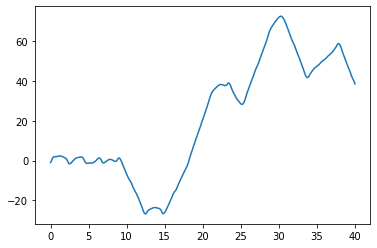

In [18]:
plt.plot(t, the2)

Here's a function that takes in $\theta_1$ and $\theta_2$ and returns the location (x,y) of the two masses.

In [19]:
def get_x1y1x2y2(t, the1, the2, L1, L2):
    return (L1*np.sin(the1),
            -L1*np.cos(the1),
            L1*np.sin(the1) + L2*np.sin(the2),
            -L1*np.cos(the1) - L2*np.cos(the2))

x1, y1, x2, y2 = get_x1y1x2y2(t, ans.T[0], ans.T[2], L1, L2)

Then we can make an animation

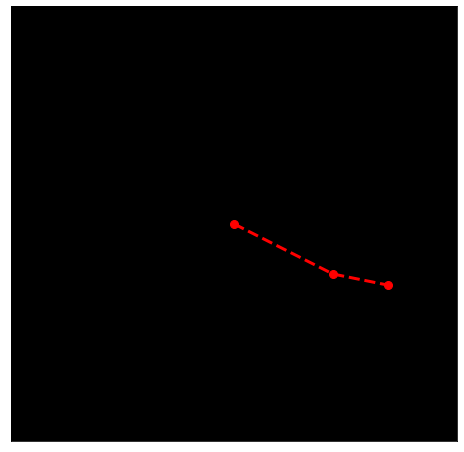

In [20]:
def animate(i):
    ln1.set_data([0, x1[i], x2[i]], [0, y1[i], y2[i]])
    
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])    # enable this to hide x axis ticks
ax.get_yaxis().set_ticks([])    # enable this to hide y axis ticks
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('pen.gif',writer='pillow',fps=25)